In [4]:
###################################################################################
# Script to plot profile data collected by CCCFA fishermen
###################################################################################
%matplotlib widget

# my own general packages
import sys
sys.path.append("./") # go to parent dir
from utils.plot_utils import finished_plot
from utils.datafun import matlab2datetime,month_converter,datetime2matlab

# load project startup file with all relevant functions
exec(open('./startup.py').read())

# get current data
from datetime import date
today = date.today()

# CCCFA profiles

In [2]:
# load data from erddap server (generated from script on clidex update_profiles_from_erdap.py)
ds = xr.open_dataset('/vast/clidex/data/obs/CCCFA/profiles_updated.nc')

In [5]:
# Rearange dataset to have array

# Step 1: Extract unique profile IDs
unique_profiles = np.unique(ds['profile_id'].values)

# Step 2: Define a standard depth range (0-250 m)
depth_range = np.arange(1, 251, 1)  # Depth in meters (0 to 250)

# Step 3: Initialize dictionaries for interpolated data and profile-level coordinates
interpolated_data = {}
profile_latitudes = []
profile_longitudes = []
profile_times = []

# Step 4: Loop over all variables and interpolate for each profile
for var in ds.data_vars:
    # Skip "profile_id" or "project_id" variables
    if var in ["profile_id", "project_id","time","longitude","latitude"]:
        print(f"Skipping variable: {var}")
        continue  # Move to the next iteration

    print(f"Interpolating variable: {var}")
    var_data = []

    for profile_id in unique_profiles:
        # Select rows belonging to the current profile_id
        profile_data = ds.where(ds['profile_id'] == profile_id, drop=True).sortby('sea_pressure')
        
        # Save profile-level latitude, longitude, and time (first value)
        if var == list(ds.data_vars)[0]:  # Collect once per profile
            profile_latitudes.append(profile_data['latitude'].values[0])
            profile_longitudes.append(profile_data['longitude'].values[0])
            profile_times.append(profile_data['time'].values[0])

        # Extract depth and variable data
        depths_raw = profile_data['sea_pressure'].values
        var_raw = profile_data[var].values

        # Remove NaNs to ensure interpolation works
        valid = ~np.isnan(depths_raw) & ~np.isnan(var_raw)
        depths_valid = depths_raw[valid]
        var_valid = var_raw[valid]

        # Interpolate the variable to the standard depth range
        interpolated_var = np.interp(
            depth_range, 
            depths_valid, 
            var_valid, 
            left=np.nan, 
            right=np.nan
        )

        var_data.append(interpolated_var)

    # Add the interpolated variable to the dictionary
    interpolated_data[var] = (["profile", "depth"], np.array(var_data))

# Step 5: Add profile-level coordinates to the dataset
ds_int = xr.Dataset(
    data_vars=interpolated_data,
    coords={
        "profile": np.arange(1,len(unique_profiles)+1),
        "depth": depth_range,
        "profile_id": ("profile",unique_profiles),
        "latitude": ("profile", profile_latitudes),
        "longitude": ("profile", profile_longitudes),
        "time": ("profile", profile_times)
    }
)

# Step 6: Save the interpolated dataset to a NetCDF file
ds_int.to_netcdf('/vast/clidex/data/obs/CCCFA/profiles_manipulated.nc')
ds_int.to_netcdf('../data/profiles_manipulated.nc')
# print(f"Interpolated dataset saved to {output_file}")

# save to matlab file
import scipy.io as sio
# Define file paths
output_matfile = '/vast/clidex/data/obs/CCCFA/profiles_manipulated.mat'  # Path for the output MATLAB file
# Convert xarray Dataset to a dictionary format that MATLAB understands
data_dict = {var: ds_int[var].values for var in ds_int.data_vars}  # Add all data variables
for coord in ds_int.coords:  # Add coordinates to the dictionary
    data_dict[coord] = ds_int[coord].values
    data_dict['time'] = datetime2matlab(ds_int['time'])
# Save the dictionary to a MATLAB .mat file using scipy
sio.savemat(output_matfile, data_dict)
sio.savemat('../data/profiles_manipulated.mat', data_dict)

# Display the resulting Dataset
# print(ds_int)

Interpolating variable: temperature
Interpolating variable: practical_salinity
Interpolating variable: absolute_salinity
Interpolating variable: conservative_temperature
Interpolating variable: density
Skipping variable: profile_id
Skipping variable: project_id
Skipping variable: time


In [8]:
# give some stats
print(f'As of today, {len(ds_int.profile)} have been collected. Latest profile on {ds_int.time[-1].values}')

As of today, 74 have been collected. Latest profile on 2024-12-10T17:34:05.937499904


Text(0.5, 1.0, '2025-03-06')

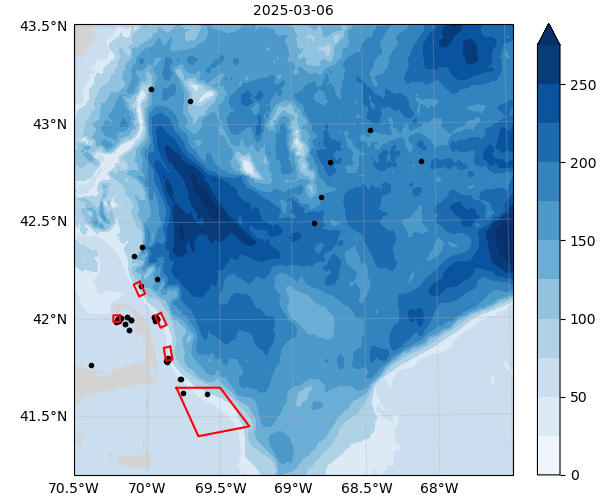

In [15]:
##################################################################################
# Make a map with all profiles
font_medium()
plt.close('all')
fig,ax = plt.subplots(figsize=(6,5),subplot_kw = dict(projection=proj),constrained_layout=True)
gl = plot_map(ax,[-70.5,-67.5,41.2,43.5],plotbathy=False)
cc=ax.contourf(bathy.x,bathy.y,bathy.z*(-1),levels=np.arange(0,300,25),extend='max',
                     transform=ccrs.PlateCarree(),cmap='Blues')
plt.colorbar(cc,shrink=0.7,label='depth [m]')
ax.plot(ds_int.longitude,ds_int.latitude,marker='.',color='k',transform=ccrs.PlateCarree(),linestyle='None')
plot_regions(ax)
ax.set_title(today)
# finished_plot(fig,'./plots/CTD/map_full_profiles.jpg')

In [10]:
ds_int

<xarray.Dataset> Size: 745kB
Dimensions:                   (profile: 74, depth: 250)
Coordinates:
  * profile                   (profile) int64 592B 1 2 3 4 5 ... 70 71 72 73 74
  * depth                     (depth) int64 2kB 1 2 3 4 5 ... 247 248 249 250
    profile_id                (profile) object 592B '322_235353_20240803_1115...
    latitude                  (profile) float64 592B 41.7 41.7 ... 41.8 41.79
    longitude                 (profile) float64 592B -69.77 -69.78 ... -69.86
    time                      (profile) datetime64[ns] 592B 2024-08-03T11:33:...
Data variables:
    temperature               (profile, depth) float64 148kB 14.76 14.73 ... nan
    practical_salinity        (profile, depth) float64 148kB 31.47 31.47 ... nan
    absolute_salinity         (profile, depth) float64 148kB 31.62 31.61 ... nan
    conservative_temperature  (profile, depth) float64 148kB 14.84 14.81 ... nan
    density                   (profile, depth) float64 148kB 1.023e+03 ... nan

In [12]:
year = 2024
ds_int.where((ds_int.time.dt.year==year) & (ds_int.time.dt.month==10),drop=True)

<xarray.Dataset> Size: 323kB
Dimensions:                   (profile: 32, depth: 250)
Coordinates:
  * profile                   (profile) int64 256B 15 16 17 18 ... 51 52 53 54
  * depth                     (depth) int64 2kB 1 2 3 4 5 ... 247 248 249 250
    profile_id                (profile) object 256B '323_235354_20241003_1028...
    latitude                  (profile) float64 256B 42.01 42.01 ... 42.0 42.0
    longitude                 (profile) float64 256B -70.19 -70.19 ... -69.93
    time                      (profile) datetime64[ns] 256B 2024-10-03T10:41:...
Data variables:
    temperature               (profile, depth) float64 64kB 17.37 17.38 ... nan
    practical_salinity        (profile, depth) float64 64kB 31.33 31.34 ... nan
    absolute_salinity         (profile, depth) float64 64kB 31.48 31.49 ... nan
    conservative_temperature  (profile, depth) float64 64kB 17.46 17.47 ... nan
    density                   (profile, depth) float64 64kB 1.023e+03 ... nan

In [ ]:
##############################
# make a map for each month
plt.close('all')
for year in np.unique(ds_int.time.dt.year.values):
    for i in range(12):
        fig,ax = plt.subplots(figsize=(6,5),subplot_kw = dict(projection=proj),constrained_layout=True)
        gl = plot_map(ax,[-70.5,-67.5,41.2,43.5],plotbathy=False)
        cc=ax.contourf(bathy.x,bathy.y,bathy.z*(-1),levels=np.arange(0,300,25),extend='max',
                             transform=ccrs.PlateCarree(),cmap='Blues')
        plt.colorbar(cc,shrink=0.7)
        ax.plot(ds_int.longitude,ds_int.latitude,marker='.',color='k',transform=ccrs.PlateCarree(),linestyle='None')
        plot_regions(ax)
        ax.set_title(today)

In [255]:
# create dictionary with extents used to plot region specific maps
ext_rs = {}
ext_rs['rs1'] = [-70.5,-70,41.7,42.1]
ext_rs['rs2'] = [-70.2,-69.9,42,42.4]
ext_rs['rs3'] = [-70.1,-69.8,41.9,42.1]
ext_rs['rs4'] = [-70,-69.7,41.7,41.9]
ext_rs['rs5'] = [-69.88,-69.2,41.25,41.75]

Saving ./plots/map_rs1_profiles.jpg
Saving ./plots/map_rs2_profiles.jpg
Saving ./plots/map_rs3_profiles.jpg
Saving ./plots/map_rs4_profiles.jpg
Saving ./plots/map_rs5_profiles.jpg


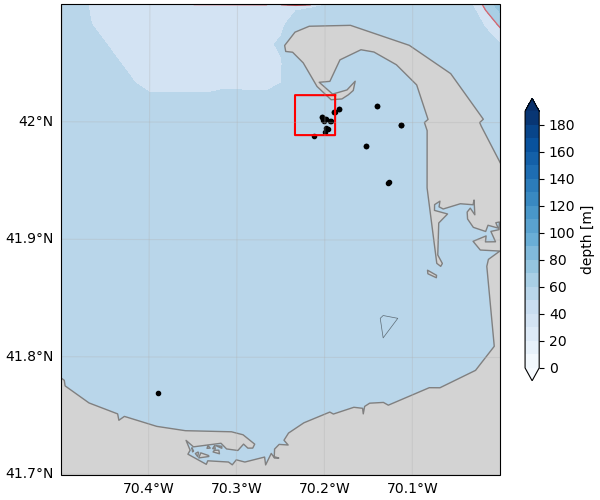

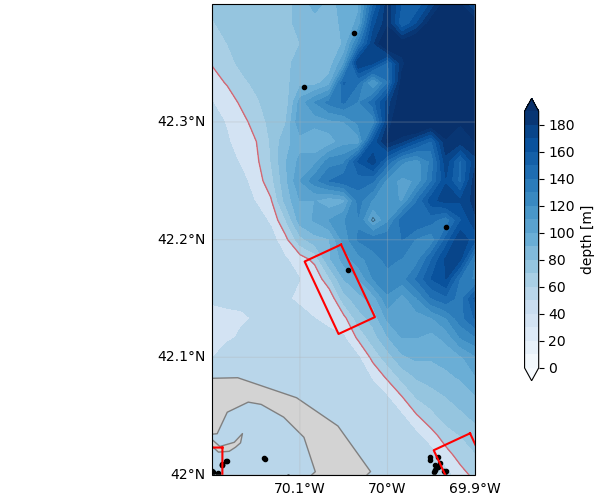

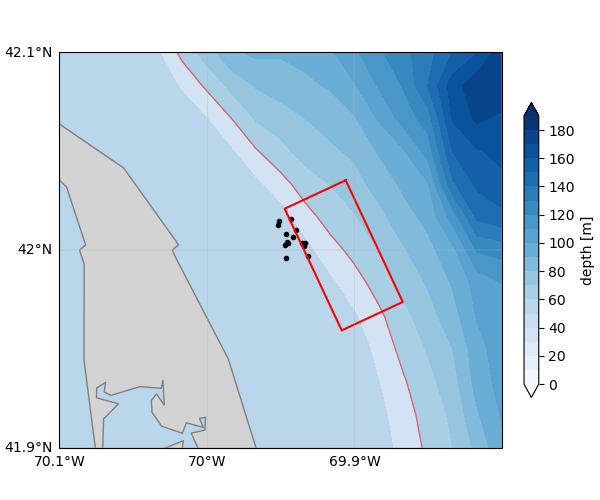

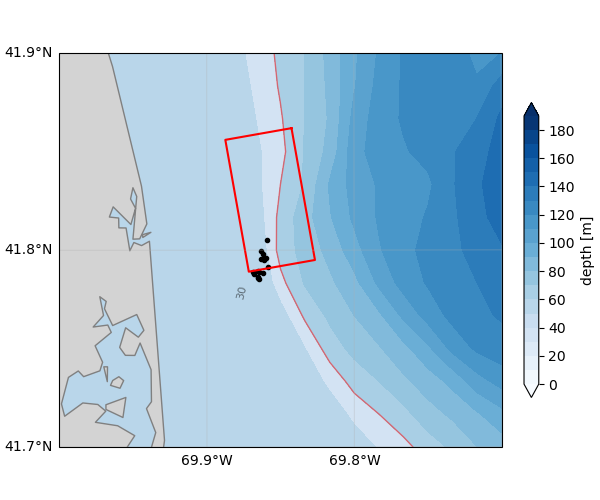

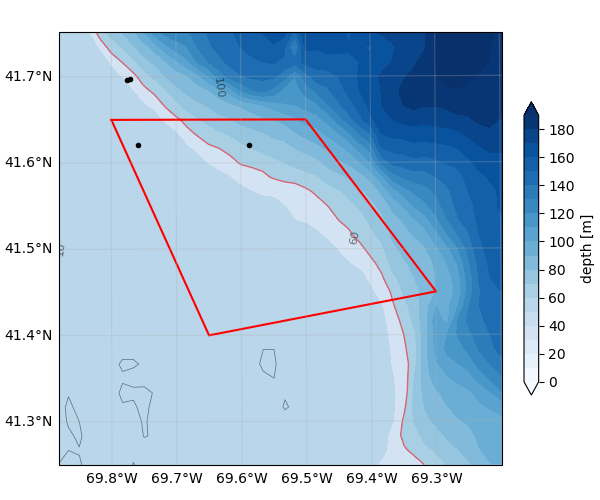

In [256]:
# plot map for each regions
plt.close('all')
for reg in ext_rs.keys():
    fig,ax = plt.subplots(figsize=(6,5),subplot_kw = dict(projection=proj),constrained_layout=True)
    gl = plot_map(ax,ext_rs[reg],plotbathy=True,inc=0.1)
    ax.plot(ds_int.longitude,ds_int.latitude,marker='.',color='k',transform=ccrs.PlateCarree(),linestyle='None')
    plot_regions(ax)
    finished_plot(fig,f'./plots/map_{reg}_profiles.jpg')

Saving ./plots/profiles_rs1_temperature_Aug_Dec2024.jpg
Saving ./plots/profiles_rs1_practical_salinity_Aug_Dec2024.jpg
Saving ./plots/profiles_rs1_density_Aug_Dec2024.jpg
Saving ./plots/profiles_rs2_temperature_Aug_Dec2024.jpg
Saving ./plots/profiles_rs2_practical_salinity_Aug_Dec2024.jpg
Saving ./plots/profiles_rs2_density_Aug_Dec2024.jpg
Saving ./plots/profiles_rs3_temperature_Aug_Dec2024.jpg
Saving ./plots/profiles_rs3_practical_salinity_Aug_Dec2024.jpg
Saving ./plots/profiles_rs3_density_Aug_Dec2024.jpg
Saving ./plots/profiles_rs4_temperature_Aug_Dec2024.jpg
Saving ./plots/profiles_rs4_practical_salinity_Aug_Dec2024.jpg
Saving ./plots/profiles_rs4_density_Aug_Dec2024.jpg
Saving ./plots/profiles_rs5_temperature_Aug_Dec2024.jpg
Saving ./plots/profiles_rs5_practical_salinity_Aug_Dec2024.jpg
Saving ./plots/profiles_rs5_density_Aug_Dec2024.jpg
Saving ./plots/profiles_GoM_temperature_Aug_Dec2024.jpg
Saving ./plots/profiles_GoM_practical_salinity_Aug_Dec2024.jpg
Saving ./plots/profiles_Go

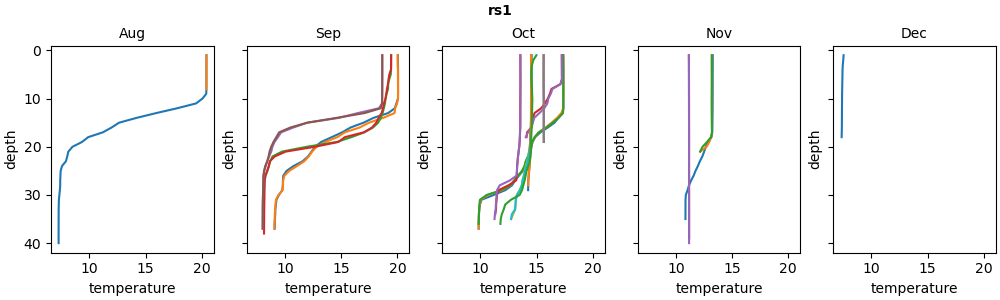

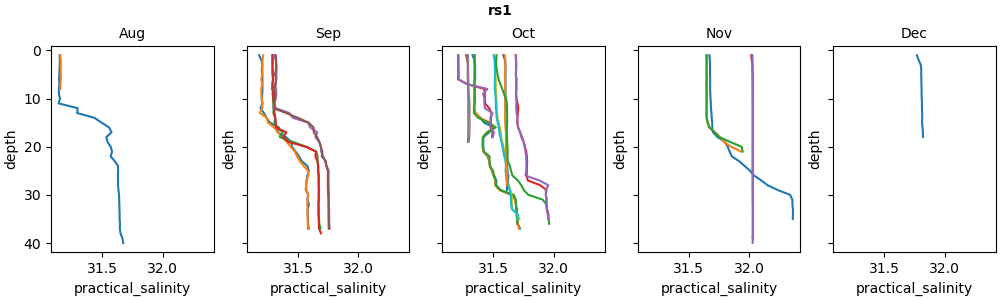

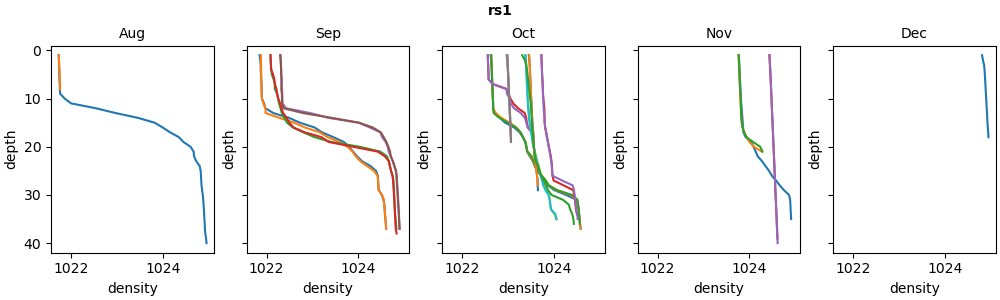

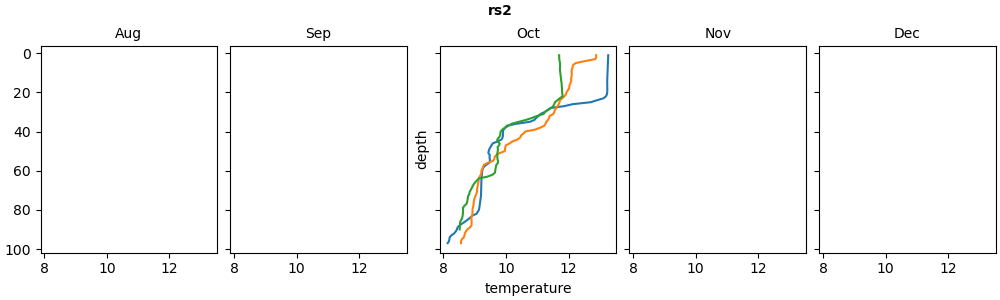

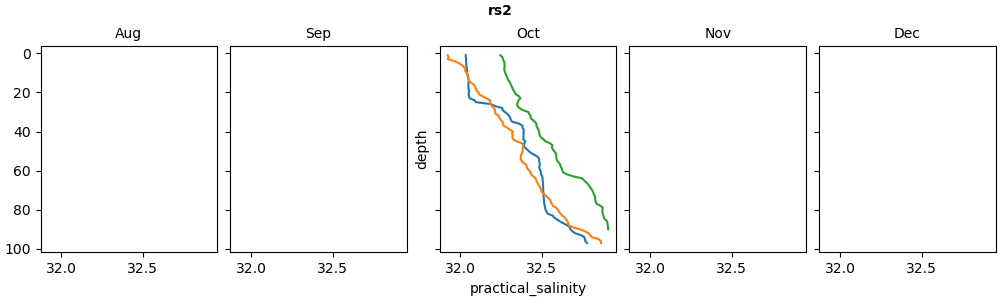

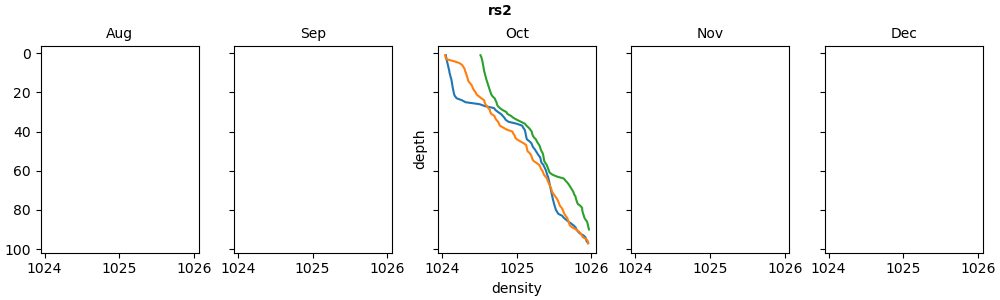

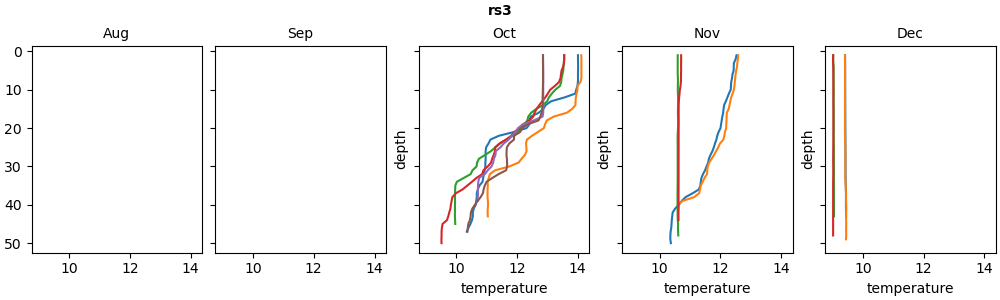

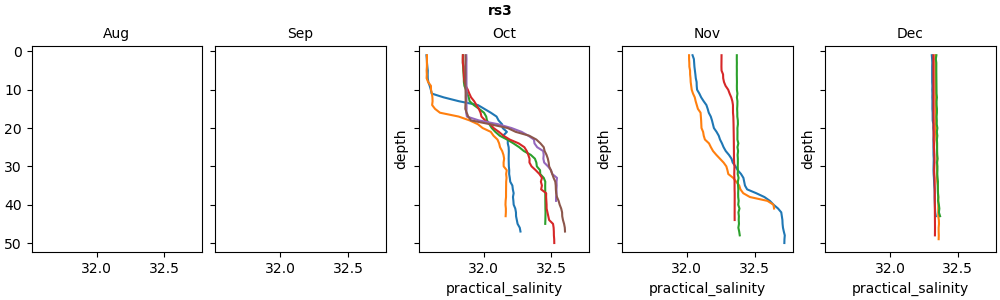

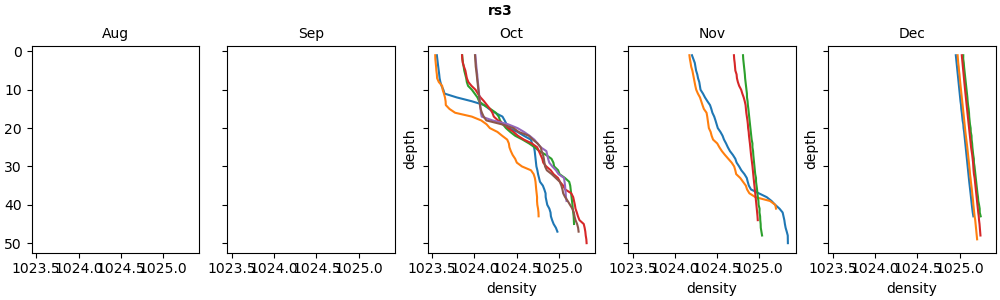

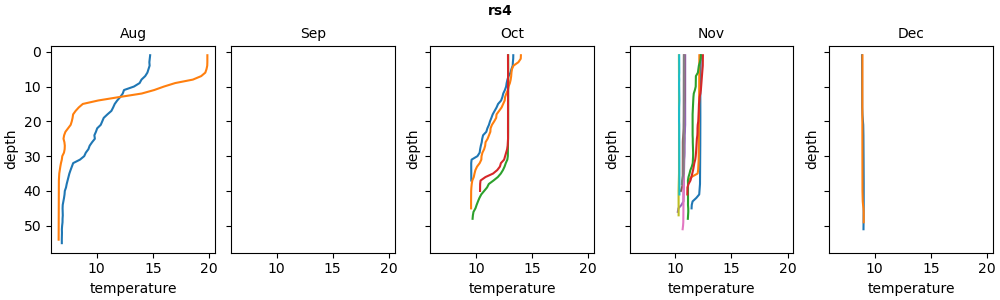

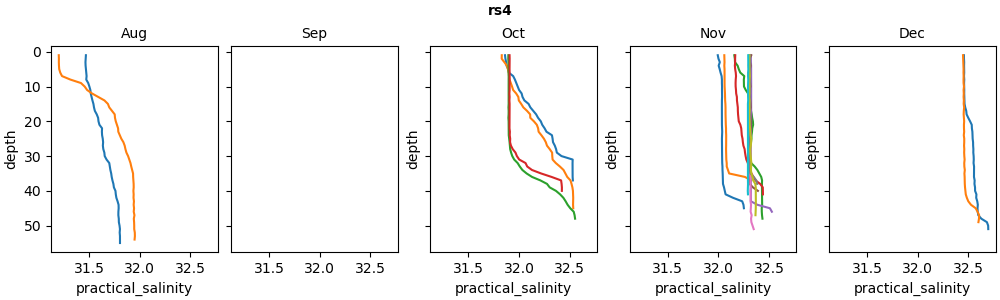

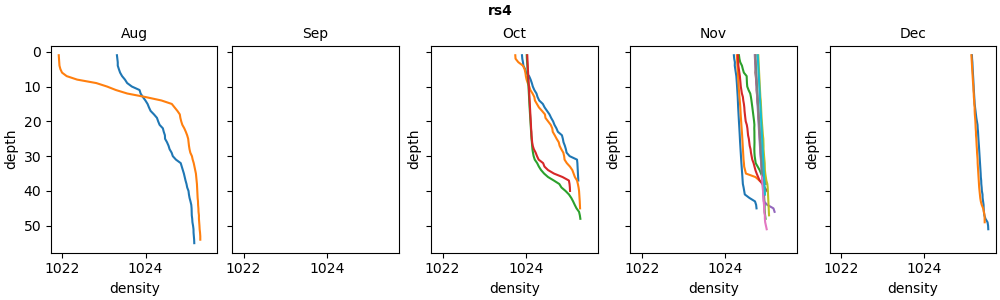

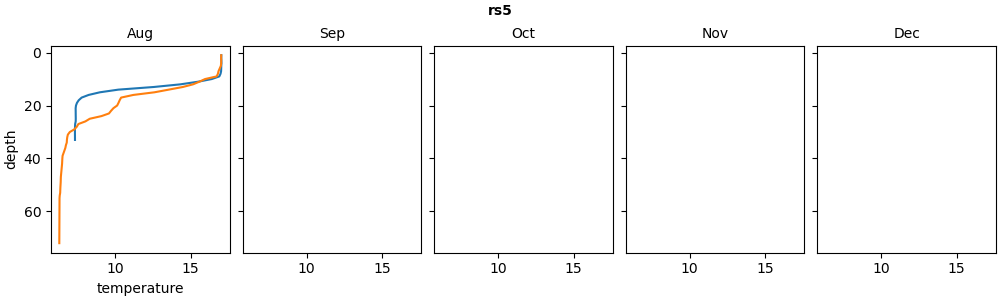

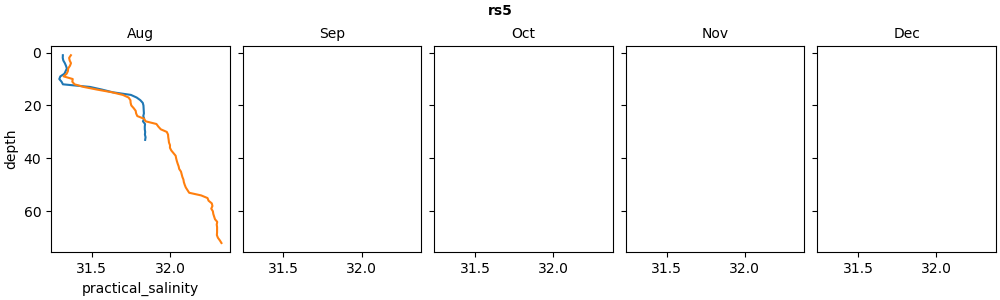

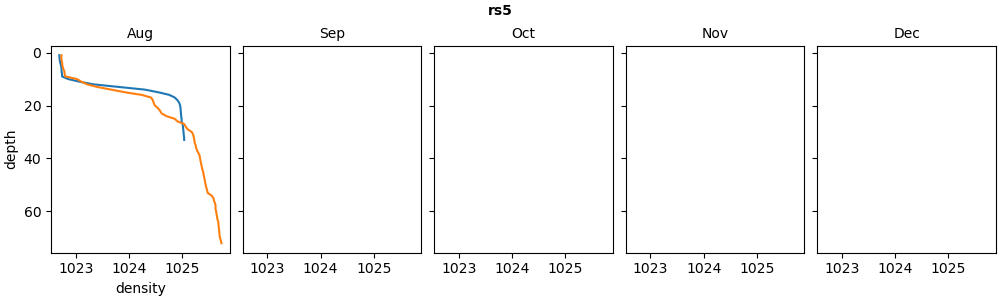

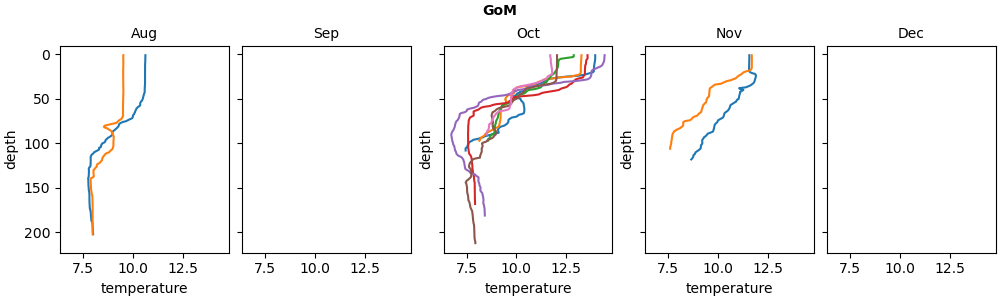

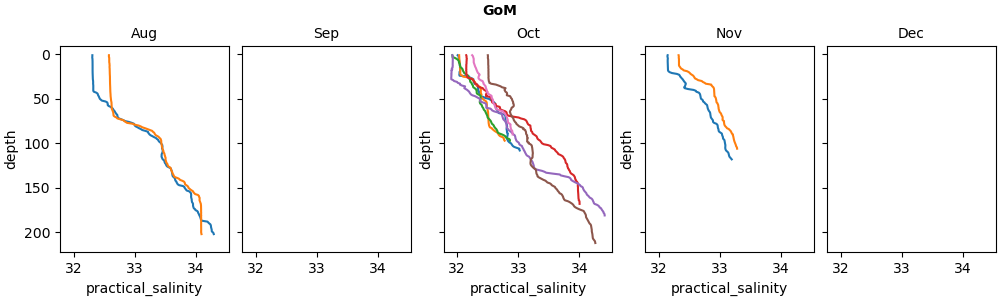

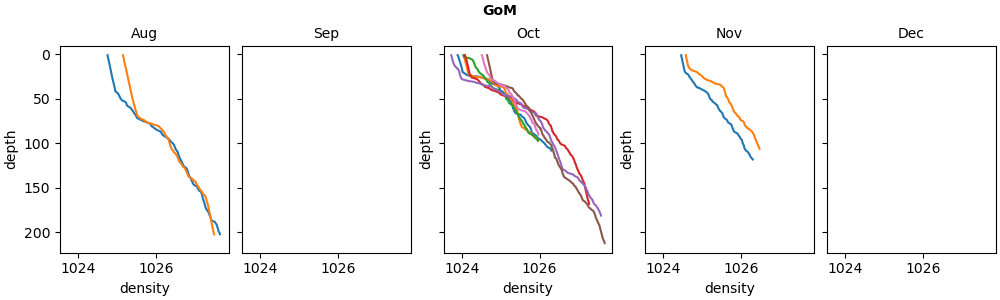

In [258]:
#########################################################
# plot subplots with profiles for each regions
#########################################################

# extract data for each regions
rs1 = ds_int.where((ds_int.longitude<-70) & (ds_int.latitude<42.1),drop=True)
rs2 = ds_int.where((ds_int.longitude<-70) & (ds_int.latitude>42.15),drop=True)
rs3 = ds_int.where((ds_int.longitude>-70) & (ds_int.latitude<42.15) & (ds_int.latitude>41.85),drop=True)
rs4 = ds_int.where((ds_int.longitude>-70) & (ds_int.latitude<41.85) & (ds_int.latitude>41.65),drop=True)
rs5 = ds_int.where((ds_int.longitude>-70) & (ds_int.latitude<41.65)  ,drop=True)
GoM = ds_int.where((ds_int.latitude>42.15),drop=True)


plt.close('all')
for ds,label in zip([rs1,rs2,rs3,rs4,rs5,GoM],['rs1', 'rs2', 'rs3', 'rs4', 'rs5','GoM']):
    for var in ['temperature','practical_salinity','density']:
        fig,ax = plt.subplots(figsize=(10,3),ncols=5,sharex=True,sharey=True,constrained_layout=True)
        for month,i in zip([8,9,10,11,12],range(5)):
            dummy = ds[var].where(ds['time'].dt.month==month,drop=True)
            if len(dummy.values)>0:
                dummy.plot.line(ax=ax[i],hue='profile',y='depth',yincrease=False)
                    # Set custom labels for the legend
                handles, labels = ax[i].get_legend_handles_labels()
                ax[i].legend(handles, ['Custom Label A', 'Custom Label B'], fontsize=8)
            ax[i].set_title(month_converter(month))
            # Set legend properties using kwargs
        fig.suptitle(label)
        finished_plot(fig,f'./plots/profiles_{label}_{var}_Aug_Dec2024.jpg')